# E06 Stock Price Prediction  
###### 온라인 코어 2기 박수경

## 1. 목표  
- 1.  시계열의 안정성이 충분히 확인되었는가? (adfuller 메소드_시각화, 플로팅 활용)
- 2.  아리마 모델의 모수를 선택하는 과정과 근거를 체계적이고 충분히 제시  
- 3.  예측 모델을 만들고 3개 이상의 종목이 MAPE 15% 미만의 정확도로 예측.

## 2. 시계열 데이터 불러오기 및 확인

가장 먼저 필요한 라이브러리를 불러오고 데이터셋을 불러온다. 이번 과제에서는 yahoo finance에서 나스닥 게임 관련주인 ATVI(activision Blizzard), TTWO(Take-two interactive), EA(Electronic Arts Inc.)의 데이터셋을 다운받아 분석을 해 보려고 한다. 먼저 시계열의 특징을 보기 위해 시각화를 한다. 시계열을 잘 분석하기 위해서는 시계열을 정상화하는 과정이 필요하다. 시계열이 정상적(안정적, stationary) 임을 확인할 때는, 평균, 분산, 공분산의 의미에 해당하는 이동평균, 이동표준편차, 자기공분산이 시간에 무관하게 일정해야 함을 본다. 

In [1]:
#필요한 라이브러리 불러오기
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels
import os

import warnings
warnings.filterwarnings('ignore')

In [2]:
atvi_ori = pd.read_csv('data/ATVI.csv',index_col='Date',parse_dates=True) #액티비전 블리자드 데이터
ttwo_ori = pd.read_csv('data/TTWO.csv',index_col='Date', parse_dates=True) # 테이크투 인터랙티브 데이터
ea_ori = pd.read_csv('data/EA.csv',index_col='Date', parse_dates=True) # 일렉트로닉 아츠 데이터

print('*'*50)
print('액티비전 블리자드')
display(atvi_ori.head(3))
print('*'*50)
print('테이크투 인터랙티브')
display(ttwo_ori.head(3))
print('*'*50)
print('텐센트')
display(ea_ori.head(3))

**************************************************
액티비전 블리자드


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-01-04,67.839996,68.010002,66.930000,67.199997,66.802917,9464000
2022-01-05,67.199997,67.860001,66.260002,66.290001,65.898293,14988200
2022-01-06,66.160004,66.260002,63.709999,63.820000,63.442890,15071100


**************************************************
테이크투 인터랙티브


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-01-04,177.929993,182.250000,175.259995,181.899994,181.899994,1242500
2022-01-05,181.630005,181.630005,171.529999,171.850006,171.850006,1701100
2022-01-06,169.460007,172.000000,164.369995,164.610001,164.610001,1430300


**************************************************
텐센트


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-01-04,134.320007,136.300003,133.779999,135.759995,134.995056,2110800
2022-01-05,136.300003,137.479996,133.630005,133.800003,133.046082,2531600
2022-01-06,133.279999,133.970001,129.419998,129.690002,128.959244,2270700


불러온 데이터 중 종가(Close, 하루의 장이 마감했을 때의 가격)을 이용하여 시계열 분석을 하려고 한다. 각 데이터의 'Close'열을 추출한다.

In [3]:
atvi = atvi_ori['Close']
ttwo = ttwo_ori['Close']
ea = ea_ori['Close']
table_close = pd.DataFrame({'액티비전 블리자드 종가': atvi,
 '테이크투 인터랙티브 종가': ttwo, '일렉트로닉 아츠 종가':ea })

table_close.head(5)

,액티비전 블리자드 종가,테이크투 인터랙티브 종가,일렉트로닉 아츠 종가
Date,,,
2022-01-04,67.199997,181.899994,135.759995
2022-01-05,66.290001,171.850006,133.800003
2022-01-06,63.820000,164.610001,129.690002
2022-01-07,64.040001,164.600006,131.779999
2022-01-10,63.110001,142.990005,128.899994


In [4]:
table_close.info()
table_close.describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 251 entries, 2022-01-04 to 2023-01-03
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   액티비전 블리자드 종가   251 non-null    float64
 1   테이크투 인터랙티브 종가  251 non-null    float64
 2   일렉트로닉 아츠 종가    251 non-null    float64
dtypes: float64(3)
memory usage: 7.8 KB


,액티비전 블리자드 종가,테이크투 인터랙티브 종가,일렉트로닉 아츠 종가
count,251.000000,251.000000,251.000000
mean,77.099084,129.506733,127.368804
std,3.524082,20.584629,5.527807
min,63.110001,93.570000,111.599998
25%,75.334999,117.560001,123.515003
50%,77.839996,125.320000,127.589996
75%,79.494999,143.194999,130.754998
max,82.309998,181.899994,141.500000


데이터를 불러오고 개괄과 기술통계량을 확인한 다음 결측치를 확인한다. interpolarate 는 결측치를 보간할 때 쓸 수 있는 함수로 method에 따라 결측치를 채우는방법이 달라진다. method='time'으로 결측값을 보간하게 되면 시계열 날짜 index를 기준으로 결측된 부분이 채워진다. 이 과제에서 다루는 세 데이터는 결측치가 없다. 따라서 보간하는 방법만 아래 코드로 제시한다.

In [5]:
# Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

atvi = atvi.interpolate(method='time') 
print(atvi[atvi.isna()])
print('*'*50)
ttwo = ttwo.interpolate(method='time')
print(ttwo[ttwo.isna()])
print('*'*50)
ea = ea.interpolate(method='time')
print(ea[ea.isna()])  

Series([], Name: Close, dtype: float64)
**************************************************
Series([], Name: Close, dtype: float64)
**************************************************
Series([], Name: Close, dtype: float64)


## 3. 데이터 정상화

결측치를 메꾼 데이터의 형태를 확인하기 위해 그래프를 그려본다.

In [6]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10,6

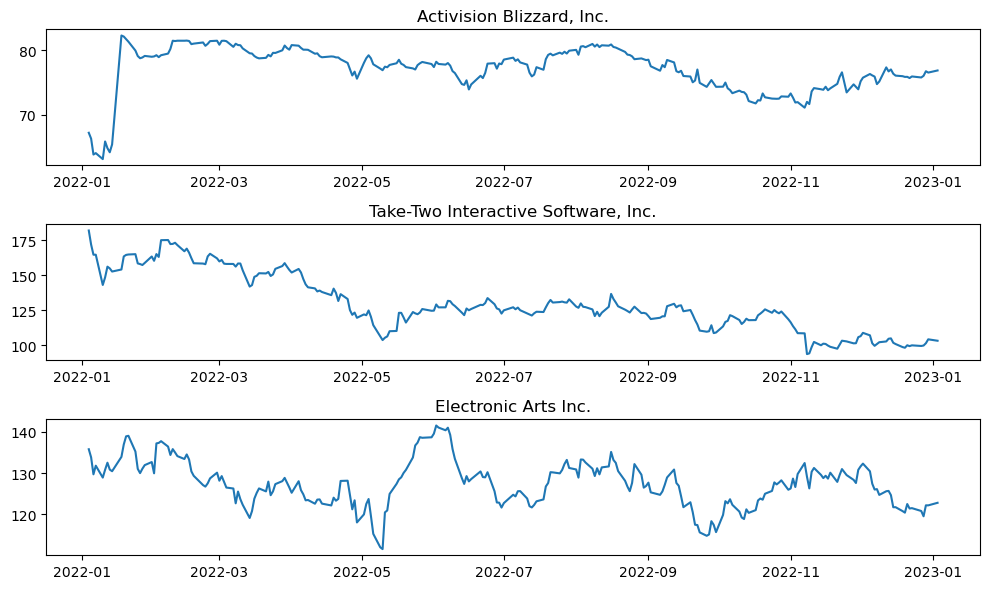

In [7]:
plt.subplot(3,1,1)
plt.plot(atvi)
plt.title('Activision Blizzard, Inc.')
plt.tight_layout()
plt.subplot(3,1,2)
plt.plot(ttwo)
plt.title('Take-Two Interactive Software, Inc.')
plt.tight_layout()
plt.subplot(3,1,3)
plt.plot(ea)
plt.title('Electronic Arts Inc.')
plt.tight_layout()

그래프를 확인하면 세 그래프 모두 정상적이라고 하기에는 추세와 계절성이 존재한다. 먼저 눈으로만 확인하면 액티비전 블리자드의 같은 경우에는 희미하게 계절성을 보이는 것 같다. 1월 초 이후에 급증해서 그 이하로 떨어진 적이 없다는 것도 확인할 수 있다.  
테이크투 인터랙티브는 전체적으로 감소하는 추세가 있는 것 같다. 그리고 그 와중에 완만한 언덕모양이 반복되는 듯한 패턴도 발견할 수 있었다. 그리고 시간이 지남에 따라 분산이 줄어드는 듯한 형태를 띄었다.
일렉트로닉 아츠의 경우 추세가 존재한다고 하기에는 애매하지만 계절성을 확인할 수 있다.  

데이터를 조금더 정상적인 상태로 분석하기 위해 로그 변환을 시도해 보았다.

In [8]:
atvi_log = np.log(atvi)
ttwo_log = np.log(ttwo)
ea_log = np.log(ea)

로그화를 한 다음 다시 그래프를 확인한다.

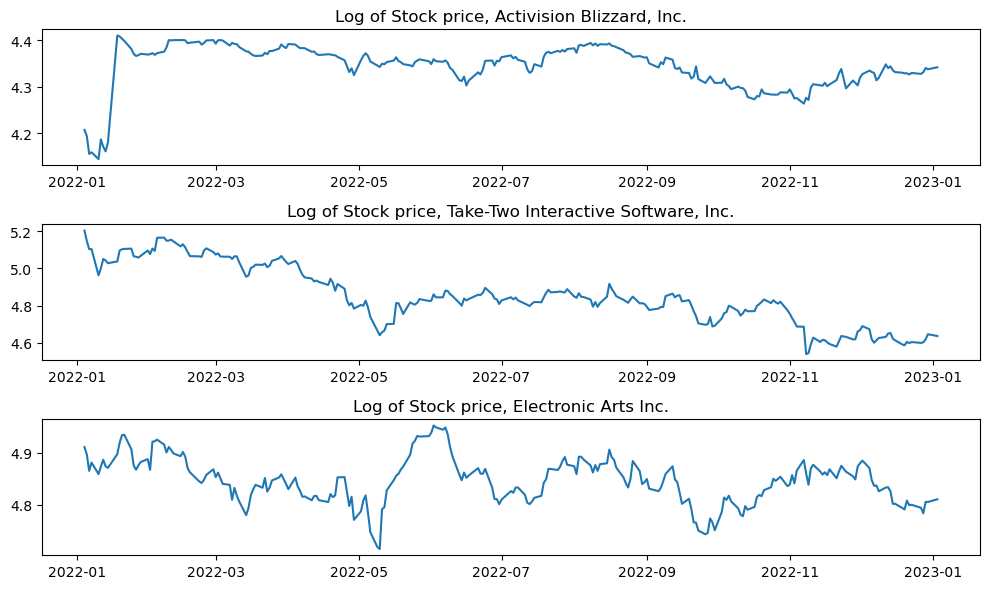

In [9]:
plt.subplot(3,1,1)
plt.plot(atvi_log)
plt.title('Log of Stock price, Activision Blizzard, Inc.')
plt.tight_layout()
plt.subplot(3,1,2)
plt.plot(ttwo_log)
plt.title('Log of Stock price, Take-Two Interactive Software, Inc.')
plt.tight_layout()
plt.subplot(3,1,3)
plt.plot(ea_log)
plt.title('Log of Stock price, Electronic Arts Inc.')
plt.tight_layout()

로그를 씌움으로서 그래프의 값이 조금 덜 출렁거리게 되었다. 하지만 여전히 희미한 등락이 보였다. 일단 추세와 계절성을 제거하기 위해 차분을 한다. 테이크투 인터랙티브는 추세를 제거하기 위한 차분과, 4-5개월을 주기로 하는 계절성이 희미하게 보이므로 계절차분도 시행해준다.  
EA는 주기를 2개월로 하는 계절 차분을 시행한다.



In [10]:
atvi_diffed = atvi_log.diff(6) # 계절차분
ttwo_diffed = ttwo_log.diff()
ttwo_diffed = ttwo_diffed.diff(4) #계절차분
ea_diffed = ea_log.diff(2)


In [11]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    rcParams['figure.figsize'] = 10,5
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

** Activision Blizzard, Inc. **


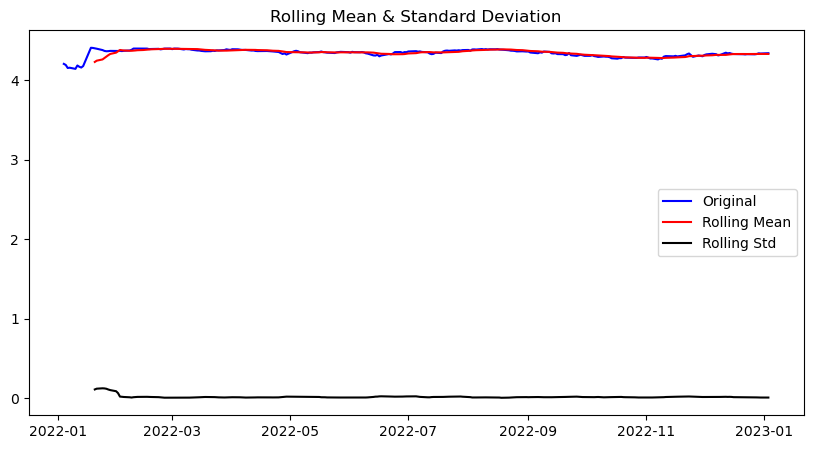

** Take-Two Interactive Software, Inc. **


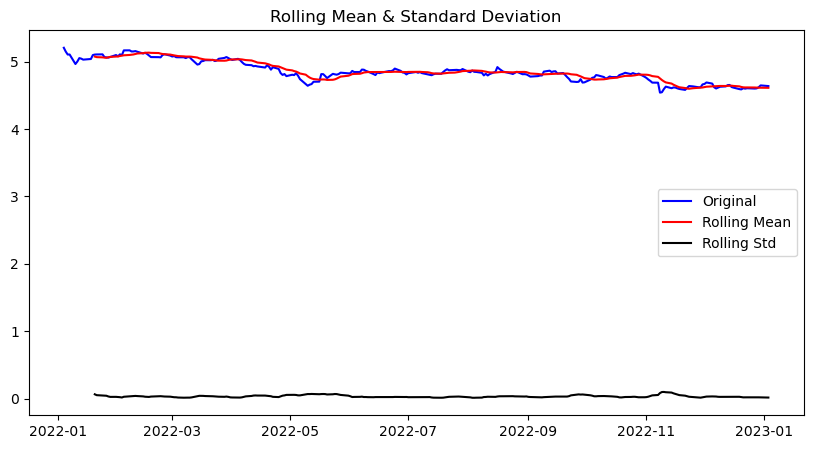

** Electronic Arts Inc. **


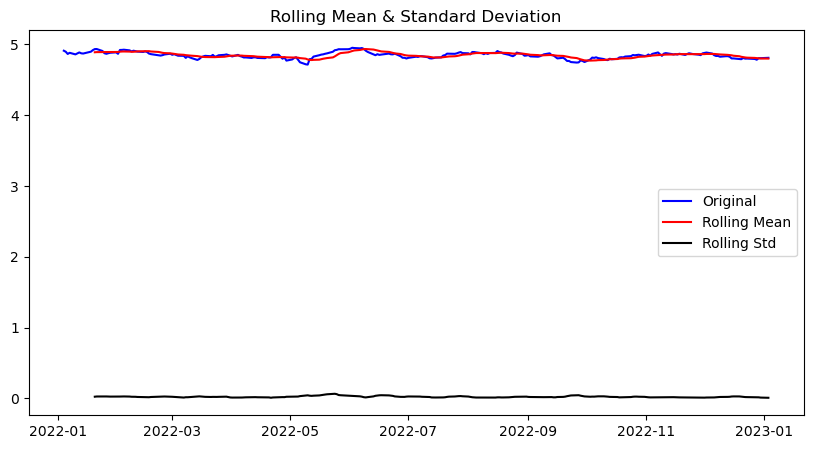

In [12]:
print('** Activision Blizzard, Inc. **')
plot_rolling_statistics(atvi_log, window=12)
print('** Take-Two Interactive Software, Inc. **')
plot_rolling_statistics(ttwo_log, window=12)
print('** Electronic Arts Inc. **')
plot_rolling_statistics(ea_log, window=12)

로그 변환만 했을 때의 이동평균과 이동표준편차이다. 테이크투 인터랙티브에서 아직 평균과 분산이 그닥 일정하지 못한 것을 확인할 수 있다. 추세도 아직 남아있는 것 같다. 따라서 차분을 한 번 더 해주기로 한다.

In [13]:
ttwo_diffed_2nd = ttwo_diffed.diff() #2차 차분

** Activision Blizzard, Inc. **


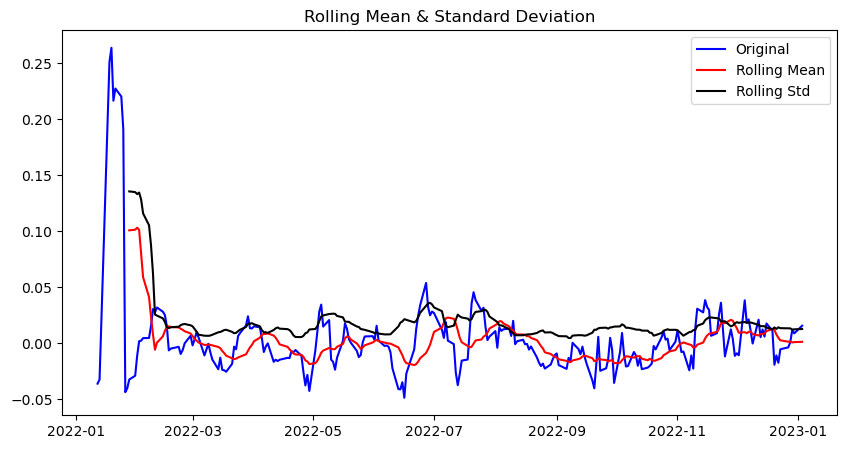

** Take-Two Interactive Software, Inc. **


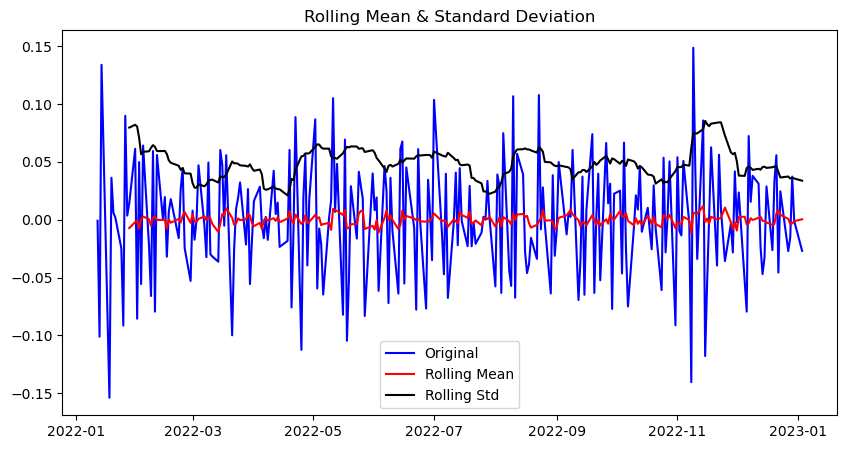

** Electronic Arts Inc. **


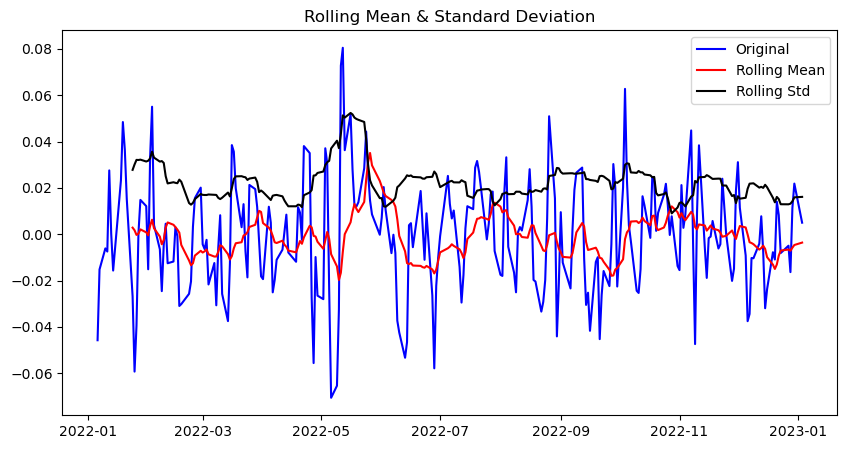

In [14]:
print('** Activision Blizzard, Inc. **')
plot_rolling_statistics(atvi_diffed, window=12)
print('** Take-Two Interactive Software, Inc. **')
plot_rolling_statistics(ttwo_diffed_2nd, window=12)
print('** Electronic Arts Inc. **')
plot_rolling_statistics(ea_diffed, window=12)

차분과 계절차분을 수행하니 데이터들의 그래프가 훨씬 정상적으로 보인다. 

## 4. 데이터의 정상성 검증

시각적인 확인 뿐 아니라 조금 더 통계적인 방법으로 정상성을 확인하기 위해 ADF 테스트를 시행한다.

In [15]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [16]:
atvi_diffed.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 251 entries, 2022-01-04 to 2023-01-03
Series name: Close
Non-Null Count  Dtype  
--------------  -----  
245 non-null    float64
dtypes: float64(1)
memory usage: 3.9 KB


In [17]:
atvi_diffed.head(12)


Date
2022-01-04         NaN
2022-01-05         NaN
2022-01-06         NaN
2022-01-07         NaN
2022-01-10         NaN
2022-01-11         NaN
2022-01-12   -0.036213
2022-01-13   -0.032503
2022-01-14    0.024303
2022-01-18    0.250985
2022-01-19    0.263668
2022-01-20    0.216409
Name: Close, dtype: float64

차분을 수행하면 데이터의 길이가짧아진다. 차분 수행으로 생긴 NaN 값을 없애준다.

In [18]:
atvi_diffed.dropna(inplace = True)
ttwo_diffed.dropna(inplace = True)
ttwo_diffed_2nd.dropna(inplace = True)
ea_diffed.dropna(inplace = True)

In [19]:
augmented_dickey_fuller_test(atvi_diffed)

Results of Dickey-Fuller Test:
Test Statistic                  -3.964561
p-value                          0.001608
#Lags Used                      12.000000
Number of Observations Used    232.000000
Critical Value (1%)             -3.458855
Critical Value (5%)             -2.874080
Critical Value (10%)            -2.573453
dtype: float64


In [20]:
augmented_dickey_fuller_test(ttwo_diffed)
print('*'*50)
augmented_dickey_fuller_test(ttwo_diffed_2nd)
print('*'*50)
augmented_dickey_fuller_test(ea_diffed)

Results of Dickey-Fuller Test:
Test Statistic                -6.980420e+00
p-value                        8.219531e-10
#Lags Used                     1.500000e+01
Number of Observations Used    2.300000e+02
Critical Value (1%)           -3.459106e+00
Critical Value (5%)           -2.874190e+00
Critical Value (10%)          -2.573512e+00
dtype: float64
**************************************************
Results of Dickey-Fuller Test:
Test Statistic                -7.411750e+00
p-value                        7.104099e-11
#Lags Used                     1.600000e+01
Number of Observations Used    2.280000e+02
Critical Value (1%)           -3.459361e+00
Critical Value (5%)           -2.874302e+00
Critical Value (10%)          -2.573571e+00
dtype: float64
**************************************************
Results of Dickey-Fuller Test:
Test Statistic                  -4.811622
p-value                          0.000052
#Lags Used                      11.000000
Number of Observations Used    23

세 데이터 모두 p-value가 0에 가깝게 나타났으므로 정상적이라는 판단을 할 수 있다. 단 액티비전 블리자드의 p밸류는 다른 데이터 두 개의 결과에 비해서는 조금 큰 값인데 이는 22년 1월 초반의 이상치때문인 것 같다.


## 5. ARIMA 모수 설정

아리마 모델은 자기 회귀 모델(AR)과 이동평균모델(MA), 차분 누적(I)을 함께 고려하는 모델이다. 아리마 모델로 값을 예측할 때에는 모수를 정하는 것이 중요하다. ARIMA의 모수는 AR의 시차 p, 차분 누적 횟수 d, MA의 시차 q가 있다. 일반적으로 p + q < 2, p * q = 0 인 값을 사용하는데, 이는 p 나 q 중 하나는 0이라는 뜻이며, 대체로 많은 시계열 데이터가 AR이나 MA 중 하나의 경향만 가지기 때문이다.  
적절한 p,q,d 를 정하기 위해 ACF와 PACF를 이용한다. ACF는 시계열의 현재 값이 과거의 값들과 어떤 연관이 있는지를 보여주고, PACF는 두 시차의 관측치를 다른 관측치의 영향을 배제한 연관성을 나타낸다. 그렇기 때문에 시계열의 현재 값이 그 이전 시간들의 가중합으로 이루어진다는 MA모델의 계수는 ACF로부터, 시계열의 현재값이 이전의 예측 오차값들의 가중합으로 이루어진다는 AR모델의 계수는 PACF로부터 얻어낼 수 있다.

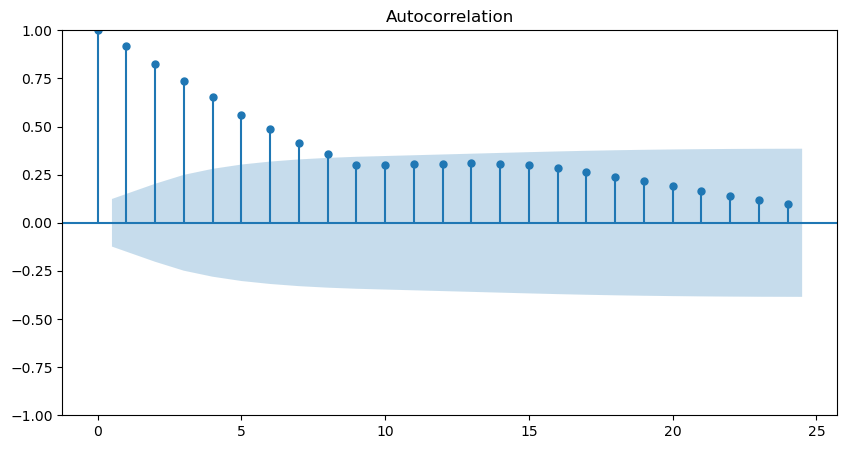

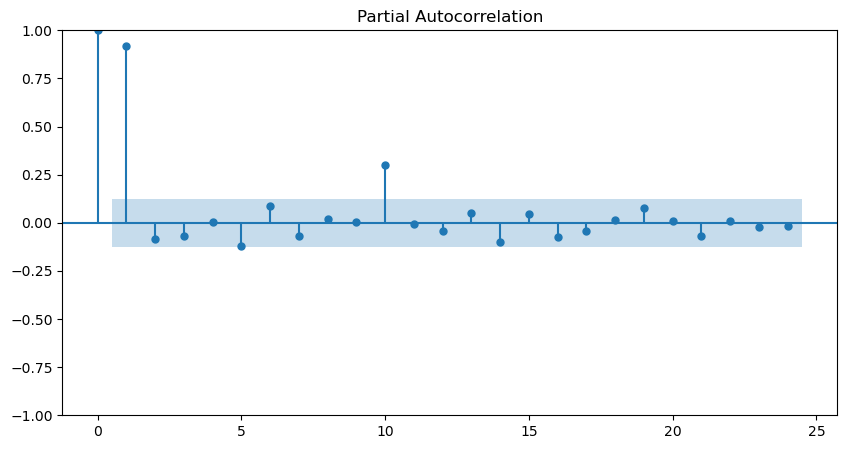

In [21]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(atvi_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(atvi_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

자기상관계수가 높을수록 그 시점의 값과 현 시점의 값이 관계가 있다는 의미이다. 우리가 정한 일정 수준의 임계값 이하로 상관계수가 떨어지면 그 때부터는 별 영향이 없다고 볼 수 있다. 또한 상관계수가 떨어지는 정도의 차이를 볼 때, 기울기가 0과 가까우면 그것도 의미가 없다. 여기서는 ARIMA 의 모수는 파랗게 음영진 부분과 상관계수 값이 만나는 정도까지의 구간길이로 볼 수 있다. 액티비전 블리자드의 경우에는 ACF 그래프가 k=8 부터는 음영 안으로 들어가므로 p=8, PACF 그래프는 1 까지 강한 상관관계를 보이고 있으므로 q=1, 그리고 차분을 1회 수행했으므로 d=1(1차)로 설정하는 것이 타당하다고 생각했다.  

추정 모수 : (8,1,1)

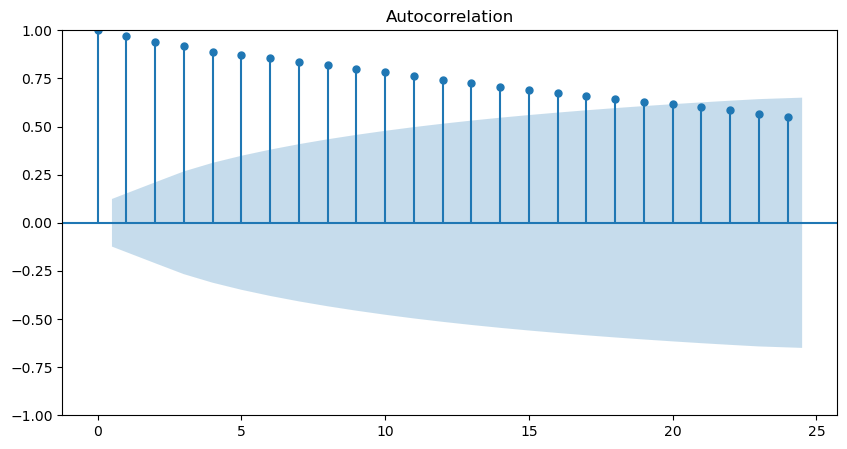

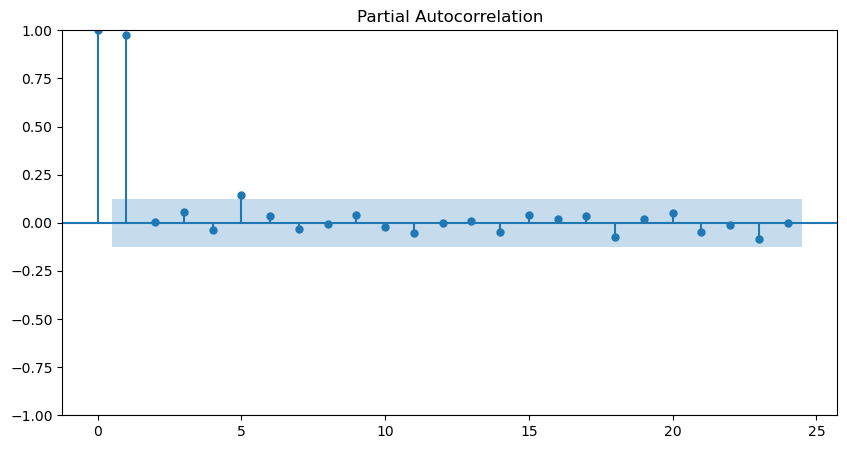

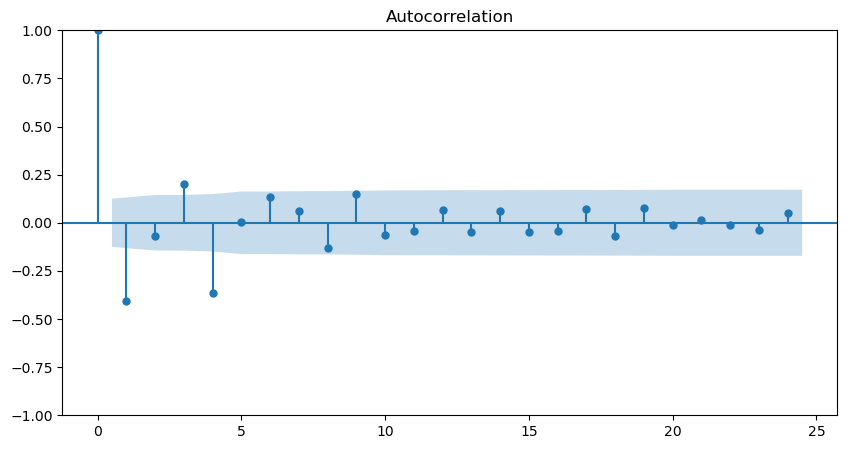

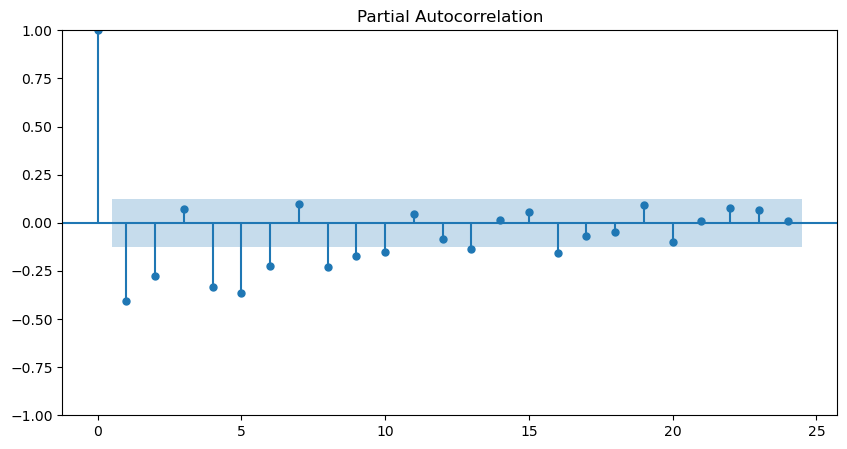

In [22]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


plot_acf(ttwo_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ttwo_log)
plot_acf(ttwo_diffed_2nd)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ttwo_diffed_2nd)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

위와 동일한 방법으로 해석하여 모수를 정했다. ACF의 그래프에서 상관계수가 줄어드는 경향이 크게 유의미하다는 생각을 하지 않았다. 0으로 설정을 하려고 한다. 차분은 2회 수행했고, 위의 ACF와 PACF의 그래프를 확인하면  정확히 어느 정도의 값을 선택해야 할지 고민이 되어서 auto_arima를 통해 최적의 모수를 찾아보기도 했다.

In [23]:
import pmdarima as pm
auto_model2 = pm.auto_arima(ttwo_diffed_2nd, d=2, trace=True)
auto_model2.fit(ttwo_diffed_2nd)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=-667.262, Time=0.09 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-230.265, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=-392.516, Time=0.06 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(3,2,2)(0,0,0)[0]             : AIC=inf, Time=0.33 sec
 ARIMA(2,2,3)(0,0,0)[0]             : AIC=inf, Time=0.26 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=inf, Time=0.32 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=0.26 sec
 ARIMA(3,2,3)(0,0,0)[0]             : AIC=inf, Time=0.37 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=-755.248, Time=0.34 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(3,2,2)(0,0,0)[0

ARIMA(order=(2, 2, 2), scoring_args={}, suppress_warnings=True)

그래프를 확인하면 (18,1,2)로 설정할 수 있다. auto_arima를 통한 최적의 모수는 (2,2,2)로 계산이 된다. 전체적인 차수가 적은 간단한 모델일수록 좋다는 원리를 따라 (2,2,2)로 하기로 한다.

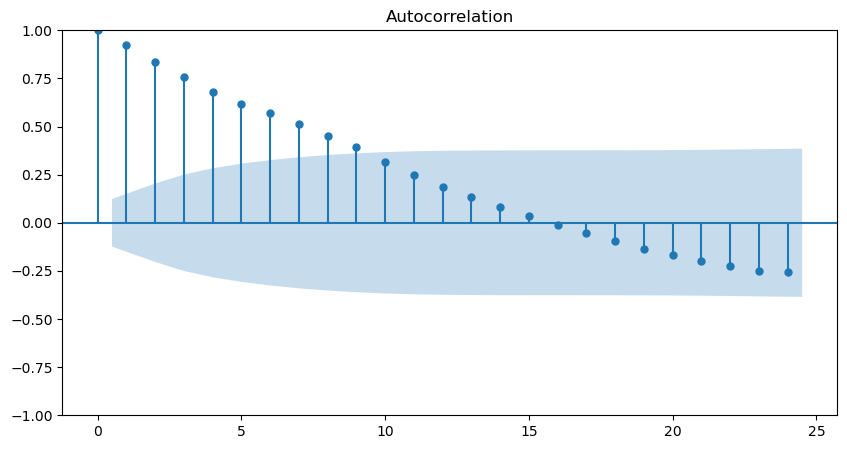

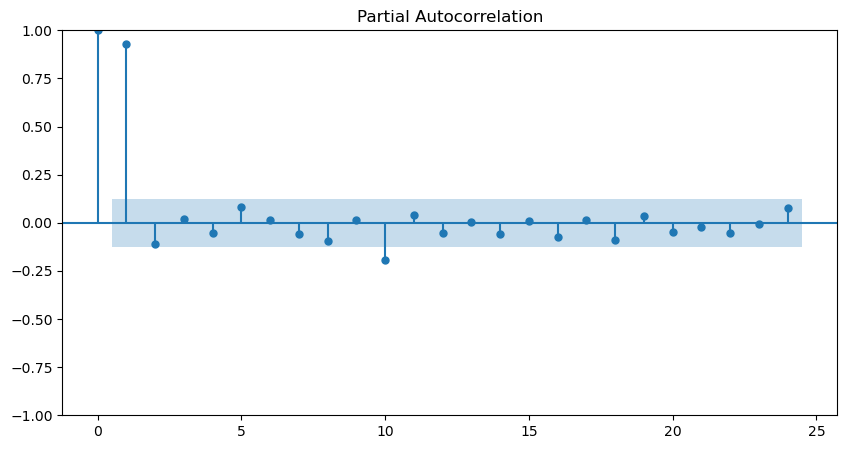

In [24]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ea_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ea_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

위와 같은 과정을 거쳐 모수를 정했다. EA 모수 설정: (9,1,1)

## 6. 학습 및 예측

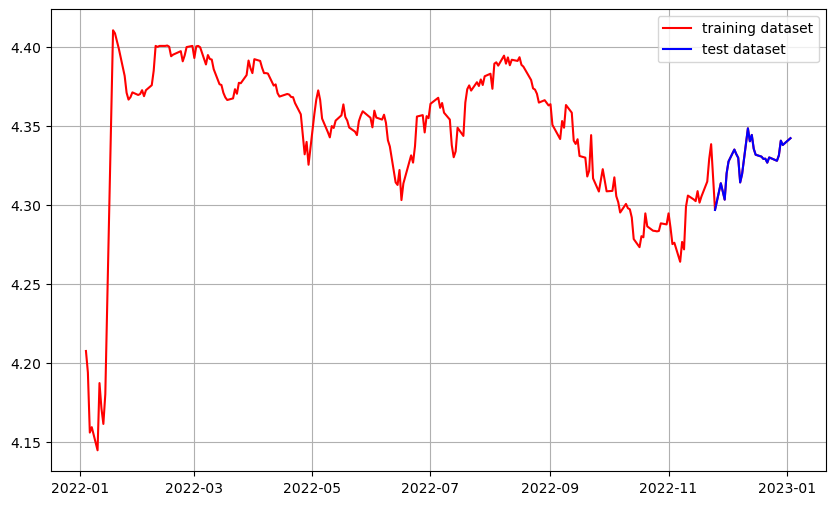

In [25]:
atvi_train_data, atvi_test_data = atvi_log[:int(len(atvi_log)*0.9)], atvi_log[int(len(atvi_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(atvi_log, c='r', label='training dataset')  
plt.plot(atvi_test_data, c='b', label='test dataset')
plt.legend()

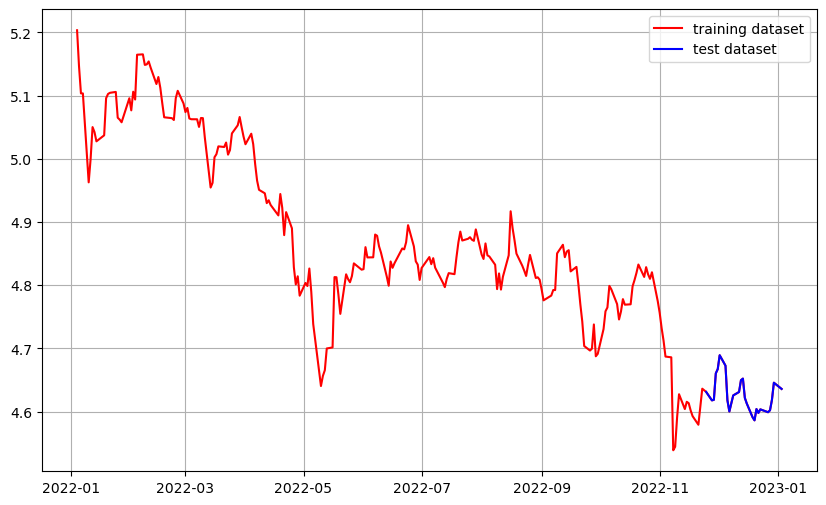

In [26]:
ttwo_train_data, ttwo_test_data = ttwo_log[:int(len(ttwo_log)*0.9)], ttwo_log[int(len(ttwo_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ttwo_log, c='r', label='training dataset')  
plt.plot(ttwo_test_data, c='b', label='test dataset')
plt.legend()

In [27]:
ttwo_test_data.index

DatetimeIndex(['2022-11-25', '2022-11-28', '2022-11-29', '2022-11-30',
               '2022-12-01', '2022-12-02', '2022-12-05', '2022-12-06',
               '2022-12-07', '2022-12-08', '2022-12-09', '2022-12-12',
               '2022-12-13', '2022-12-14', '2022-12-15', '2022-12-16',
               '2022-12-19', '2022-12-20', '2022-12-21', '2022-12-22',
               '2022-12-23', '2022-12-27', '2022-12-28', '2022-12-29',
               '2022-12-30', '2023-01-03'],
              dtype='datetime64[ns]', name='Date', freq=None)

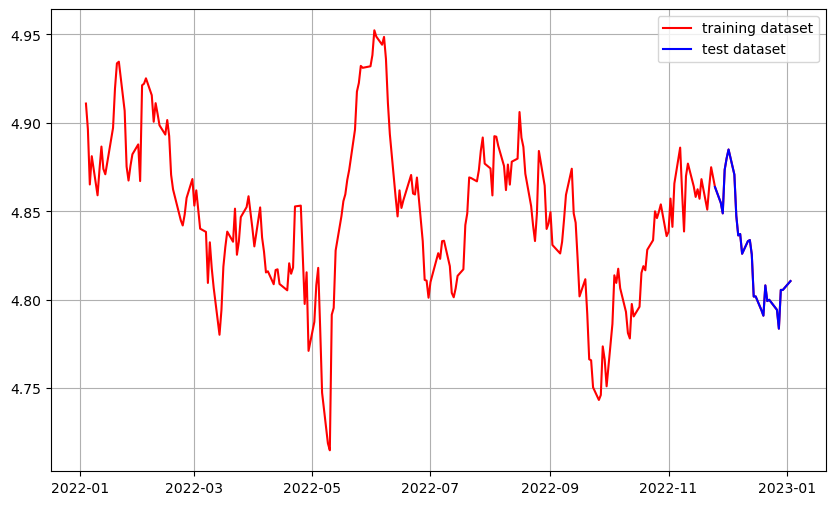

In [28]:
ea_train_data, ea_test_data = ea_log[:int(len(ea_log)*0.9)], ea_log[int(len(ea_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ea_log, c='r', label='training dataset')  
plt.plot(ea_test_data, c='b', label='test dataset')
plt.legend()

세 데이터를 9:1 로 학습데이터와 검증데이터로 잘랐다. 자른 길이를 확인할수 있다.

In [29]:
print(atvi_log[:2])
print(atvi_train_data.shape)  # 학습 데이터의 길이를 볼 수 있다.
print(atvi_test_data.shape) #테스트 데이터의 길이를 볼 수 있다.

Date
2022-01-04    4.207673
2022-01-05    4.194039
Name: Close, dtype: float64
(225,)
(26,)


검증데이터의 길이는 26 이다. 우리는 학습 데이터로 학습을 진행하여 뒤의 26일치를 예측할 것이고, 그것을 정답 데이터 atvi_test_data 와 비교하여 오차율을 구할 것이다.

액티비전 블리자드의 예측 모델 훈련부터 진행한다.

In [30]:
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model1 = ARIMA(atvi_train_data, order=(8,1,1)) # 모수는 이전 그래프를 참고 
model1_fit = model1.fit() 

print(model1_fit.summary())


c:\Users\TAN\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\TAN\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\TAN\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(8, 1, 1)   Log Likelihood                 588.351
Date:                Thu, 05 Jan 2023   AIC                          -1156.702
Time:                        19:09:16   BIC                          -1122.585
Sample:                             0   HQIC                         -1142.931
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0226     17.706      0.001      0.999     -34.680      34.726
ar.L2         -0.0572      0.868     -0.066      0.947      -1.759       1.645
ar.L3         -0.0622      1.044     -0.060      0.9

예측값 시리즈의 인덱스를 날짜로 넣어주기 위해 기존 데이터에서 인덱스 리스트를 추출했다.

In [31]:
index_list = atvi_diffed.tail(26).index
index_list

DatetimeIndex(['2022-11-25', '2022-11-28', '2022-11-29', '2022-11-30',
               '2022-12-01', '2022-12-02', '2022-12-05', '2022-12-06',
               '2022-12-07', '2022-12-08', '2022-12-09', '2022-12-12',
               '2022-12-13', '2022-12-14', '2022-12-15', '2022-12-16',
               '2022-12-19', '2022-12-20', '2022-12-21', '2022-12-22',
               '2022-12-23', '2022-12-27', '2022-12-28', '2022-12-29',
               '2022-12-30', '2023-01-03'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [32]:
fc1 = model1_fit.forecast(26)

c:\Users\TAN\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


액티비전 블리자드 주식 종가 예측을 위한 아리마 모델을 통해 26일치 값을 예측했다. 인덱스를 index_list를 이용해 정답 데이터의 날짜와 맞추어 준다.

In [33]:

fc1.index = index_list
fc1.head(3)

Date
2022-11-25    4.338785
2022-11-28    4.336621
2022-11-29    4.336692
Name: predicted_mean, dtype: float64

모델이 예측한 값을 그래프로 나타내었다.

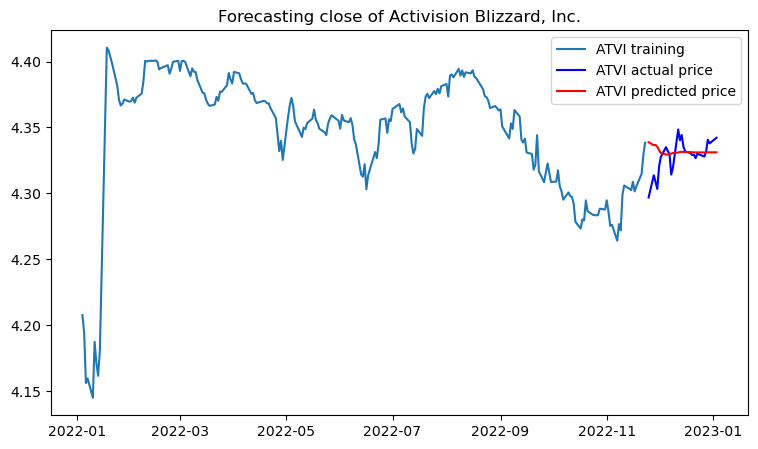

In [34]:
plt.figure(figsize=(9,5), dpi=100)
plt.title('Forecasting close of Activision Blizzard, Inc.')
plt.plot(atvi_train_data, label='ATVI training')
plt.plot(atvi_test_data, c='b', label='ATVI actual price')
plt.plot(fc1, c='r',label='ATVI predicted price')
plt.legend()
plt.show()

얼마나 모델의 성능이 좋은지를 평가하려고 한다. 예측 모델의 오차율을 알아 본다. 처음에 로그변환을 해 주었기 때문에 다시 되돌려서 계산을 해 주었다.

In [35]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(atvi_test_data), np.exp(fc1))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(atvi_test_data), np.exp(fc1))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(atvi_test_data), np.exp(fc1)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc1) - np.exp(atvi_test_data))/np.abs(np.exp(atvi_test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  1.211488714354543
MAE:  0.7582268429046457
RMSE:  1.10067648033132
MAPE: 1.01%


__**MAPE 오차율 1.01%**__ 로 꽤 준수하다고 볼 수 있다.

이어서 테이크투 인터랙티브의 종가를 예측하는 모델을 만들고, 예측한 후 위와 같은 과정으로 성능을 측정해 보았다.

In [36]:
model2 = ARIMA(ttwo_train_data, order=(2,2,2)) # 모수는 이전 그래프를 참고 
model2_fit = model2.fit() 

print(model2_fit.summary())


c:\Users\TAN\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\TAN\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\TAN\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(2, 2, 2)   Log Likelihood                 472.301
Date:                Thu, 05 Jan 2023   AIC                           -934.603
Time:                        19:09:17   BIC                           -917.567
Sample:                             0   HQIC                          -927.726
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8371      0.333     -2.514      0.012      -1.490      -0.185
ar.L2          0.0402      0.085      0.472      0.637      -0.127       0.207
ma.L1         -0.0927      0.351     -0.265      0.7

In [37]:
fc2 = model2_fit.forecast(26)

fc2.index = index_list
fc2.head(3)

c:\Users\TAN\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Date
2022-11-25    4.636641
2022-11-28    4.632869
2022-11-29    4.631526
Name: predicted_mean, dtype: float64

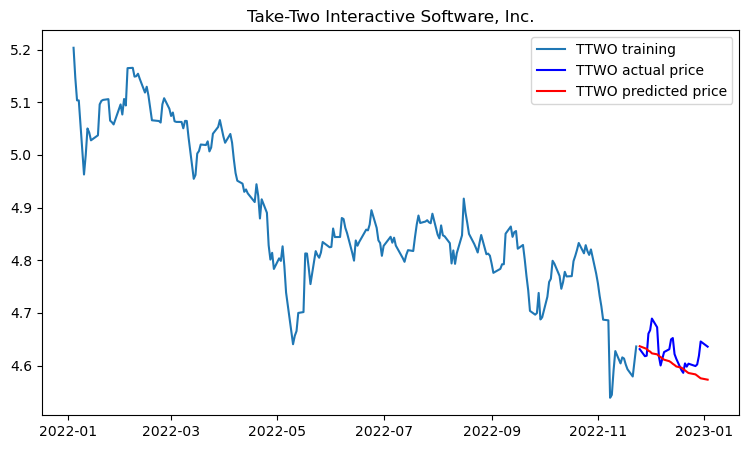

In [38]:
plt.figure(figsize=(9,5), dpi=100)
plt.title('Take-Two Interactive Software, Inc.')
plt.plot(ttwo_train_data, label='TTWO training')
plt.plot(ttwo_test_data, c='b', label='TTWO actual price')
plt.plot(fc2, c='r',label='TTWO predicted price')
plt.legend()
plt.show()

In [39]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(ttwo_test_data), np.exp(fc2))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(ttwo_test_data), np.exp(fc2))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(ttwo_test_data), np.exp(fc2)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc2) - np.exp(ttwo_test_data))/np.abs(np.exp(ttwo_test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  11.185534983203329
MAE:  2.6158028590566267
RMSE:  3.3444782826628323
MAPE: 2.52%


테이크투 인터랙티브 종가 예측 모델의 성능 지표로 MAPE를 보면 **오차율 2.52%** 을 보이고 있다.

이어서 일렉트로닉 아츠 종가에 대해서도 같은 과정을 수행한다.

In [40]:
model3 = ARIMA(ea_train_data, order=(9,1,2)) # 모수는 이전 그래프를 참고 
model3_fit = model3.fit() 

print(model3_fit.summary())

c:\Users\TAN\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\TAN\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\TAN\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(9, 1, 2)   Log Likelihood                 602.646
Date:                Thu, 05 Jan 2023   AIC                          -1181.292
Time:                        19:09:17   BIC                          -1140.352
Sample:                             0   HQIC                         -1164.767
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2238      0.931     -0.240      0.810      -2.048       1.601
ar.L2          0.1567      0.674      0.233      0.816      -1.163       1.477
ar.L3         -0.0446      0.074     -0.602      0.5

c:\Users\TAN\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [41]:
fc3 = model3_fit.forecast(26)

fc3.index = index_list
fc3.head(3)

c:\Users\TAN\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Date
2022-11-25    4.874196
2022-11-28    4.874104
2022-11-29    4.872833
Name: predicted_mean, dtype: float64

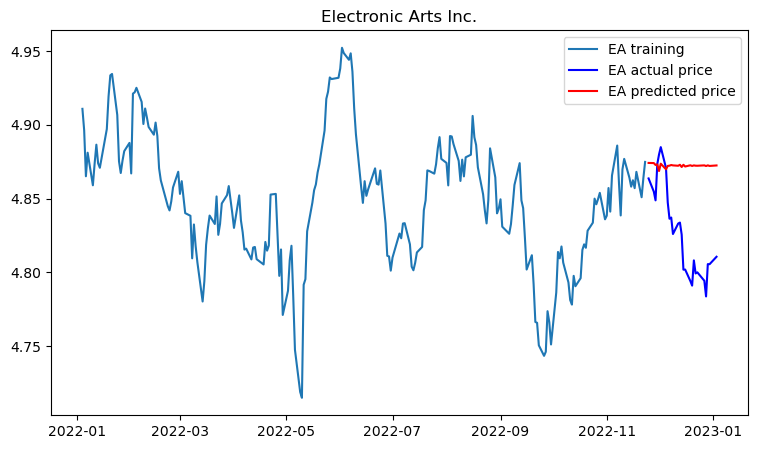

In [42]:
plt.figure(figsize=(9,5), dpi=100)
plt.title('Electronic Arts Inc.')
plt.plot(ea_train_data, label='EA training')
plt.plot(ea_test_data, c='b', label='EA actual price')
plt.plot(fc3, c='r',label='EA predicted price')
plt.legend()
plt.show()

In [43]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(ea_test_data), np.exp(fc3))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(ea_test_data), np.exp(fc3))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(ea_test_data), np.exp(fc3)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc3) - np.exp(ea_test_data))/np.abs(np.exp(ea_test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  46.580324511757944
MAE:  5.931858206502393
RMSE:  6.824977986173871
MAPE: 4.83%


일렉트로닉 아츠는 **오차율 4.83%** 를 보이고 있다.

## 7. Discussion

- 액티비전 22년 1월 주식 종가에 이상치로 판단할 수 있는 부분이 있었다. 적절하게 처리하는 방법을 몰라 그래도 진행하였지만 조금 더 잘 다루고 싶었다. 이상치를 판단하고 그 값을 적당한 값으로 바꿔줄 수 있겠다는 생각을 과제가 끝나고 나서 했다. 다음번에는 미리 이상치를 잘 처리하여 더 오차율을 낮추고 싶다.  

- 처음 테이크투 인터랙티브의 차분 결과로 이동평균, 이동표준편차 그래프를 그렸을 때 여전히 평균값과 표준편차값이 시간에 따라 변하는 것을 확인하고 한번 더 차분했다. 데이터의 정상성을 확보하기 위해 연속적으로 차분을 하는 경우를 직접 겪어보아서 더욱 기억에 잘 남을 것 같다. 결국에는 데이터의 정상성을 최대한 확보하기 위해 다양한 방법론에 익숙해져야 겠다고 다짐했다.

- 차분을 진행하거나 계절 차분을 수행해도 계절성과 추세가 희미하게 남아있는 데이터가 있었다. 그런 경우는 조금 더 차분을 진행해야 하는것일까 하는 의문이 남았다. 차분 과정을 거칠수록 ARIMA모델이 복잡해져서 차분은 2회까지만 하자고 생각했기에 더 진행하지 않았지만 조금더 데이터를 정상화 시키려면 그 이상 했어야 하나 궁금하다.  

- ACF 그래프와 PACF 그래프를 읽는 방법에 조금 익숙해졌다고 생각했는데 차분한 결과로 다시 ACF, PACF 그래프를 살펴보았을때의 의미가 아직 잘 와닿지 않는다. 다시 기본적인 수식을 보고 의미를 알아야겠다고 생각했다. ![](data/ARIMA.PNG)  
시간차 구간을 지나오면서 그 구간의 값들에 다 영향 받는 것을 고려한 AR 모델, 그리고 한 시점과 현 시점의 차이에서 다른 구간들을 지나오며 받은 영향을 배제하고 표현한 MA모델의 항들이 의미하는 것을 다시 생각해보니, ARIMA 모델의 원리와 모수를 정하는 방법을 조금 더 잘 알 수 있었다.

## 8. References  

- 결측치 보간 interpolate (https://rfriend.tistory.com/264)  
- 유의수준과 P-Value (https://agronomy4future.org/?p=6686)  
- 단위근과 자기상관 검정 (https://blessedby-clt.tistory.com/39)  
- ACF, PACF를 근거로 ARIMA 모수 추정 
 (https://leedakyeong.tistory.com/entry/ARIMA%EB%9E%80-ARIMA-%EB%B6%84%EC%84%9D%EA%B8%B0%EB%B2%95-AR-MA-ACF-PACF-%EC%A0%95%EC%83%81%EC%84%B1%EC%9D%B4%EB%9E%80)   
 - AUTO ARIMA로 최적 모수 찾기 (https://assaeunji.github.io/data%20analysis/2021-09-25-arimastock/)  